
##### 이 노트북은 CIFAR-10 데이터셋을 사용한 이미지 분류 실험입니다.

In [1]:
# ============================================================
# 1. Python path 설정
# ============================================================
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: /Users/seoyeonmun/CV_competition_practice/CV_competition_practice


In [2]:
# ============================================================
# 2. Ensure inline plotting in this notebook
# ============================================================
%matplotlib inline


In [3]:
# ============================================================
# 3. 기본 라이브러리 임포트 및 MPS 설정
# ============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f"PyTorch: {torch.__version__}")
print(f"MPS: {torch.backends.mps.is_available()}")

PyTorch: 2.5.1
MPS: True


In [4]:
# ============================================================
# 4. 하이퍼파라미터 설정
# ============================================================
from src.config import print_config, update_config

# 현재 설정 확인
print_config()

# 필요시 하이퍼파라미터 수정 (아래 주석 해제하여 사용)
update_config(
#     MODEL_NAME='efficientnet_b0',
#     BATCH_SIZE=64,
     EPOCHS=1,
#     LR=0.001,
     N_FOLDS=2,
#     PATIENCE=5,
#     IMAGE_SIZE=224,
#     USE_SUBSET=False,
#     SUBSET_RATIO=0.1
 )

{'MODEL_NAME': 'efficientnet_b0', 'BATCH_SIZE': 32, 'N_FOLDS': 2, 'EPOCHS': 1, 'LR': 0.001, 'PATIENCE': 5, 'IMAGE_SIZE': 224, 'USE_SUBSET': True, 'SUBSET_RATIO': 0.1}
⚙️  실험 설정 (Hyperparameters)

📦 모델 설정:
  - 모델:              efficientnet_b0
  - 이미지 크기:       224x224

🎯 학습 설정:
  - Batch Size:        32
  - Epochs:            1
  - Learning Rate:     0.001
  - K-Fold:            2
  - Early Stop:        5 epochs

💾 데이터 설정:
  - 서브셋 사용:       Yes
  - 서브셋 비율:       10.0%

🖥️  디바이스:
  - Device:            mps
✅ Config 업데이트 완료!
⚙️  실험 설정 (Hyperparameters)

📦 모델 설정:
  - 모델:              efficientnet_b0
  - 이미지 크기:       224x224

🎯 학습 설정:
  - Batch Size:        32
  - Epochs:            1
  - Learning Rate:     0.001
  - K-Fold:            2
  - Early Stop:        5 epochs

💾 데이터 설정:
  - 서브셋 사용:       Yes
  - 서브셋 비율:       10.0%

🖥️  디바이스:
  - Device:            mps


In [5]:
# ============================================================
# 5. Wandb 초기화
# ============================================================
import wandb
from src.config import MODEL_NAME, BATCH_SIZE, EPOCHS, LR, N_FOLDS, IMAGE_SIZE, PATIENCE, USE_SUBSET, SUBSET_RATIO
from src.model import MODEL_DISPLAY_NAME, SELECTED_MODEL

# Wandb 로그인 (최초 1회만 필요, 주석 해제)
# wandb.login()

# 실험 초기화
wandb.init(
    project="cifar10-classification",
    name=f"{MODEL_NAME}_bs{BATCH_SIZE}_ep{EPOCHS}",
    config={
        "model": MODEL_DISPLAY_NAME,
        "model_architecture": SELECTED_MODEL,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LR,
        "n_folds": N_FOLDS,
        "image_size": IMAGE_SIZE,
        "patience": PATIENCE,
        "use_subset": USE_SUBSET,
        "subset_ratio": SUBSET_RATIO if USE_SUBSET else 1.0
    }
)

print(f"✅ Wandb 초기화 완료: {wandb.run.name}")


🎯 선택된 모델: EfficientNet-B0 (efficientnet_b0)


wandb: Currently logged in as: aboutexo04 (aboutexo04-korea-open-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Wandb 초기화 완료: efficientnet_b0_bs32_ep1


In [6]:
# ============================================================
# 6. Data 로드
# ============================================================

from src.config import *
from src.data import *
print(f"\n✅ 데이터 로드 완료")
print(f"Train: {len(train_dataset_raw):,}, Test: {len(test_dataset):,}")

Using device: MPS (Apple Silicon)
📦 Loading CIFAR10 Data (from pickle files)
✅ Loading CIFAR10 data from pickle files...

✅ CIFAR10 Data Loaded!
Train: 50,000 images
Test:  10,000 images
Classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Location: /Users/seoyeonmun/CV_competition_practice/CV_competition_practice/data/cifar-10-batches-py


/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


🔥 발열 감소 모드: 데이터셋 10% 사용
✅ Total train size: 5,000
✅ Test size: 1,000

💡 전체 데이터로 학습하려면 USE_SUBSET = False로 변경하세요

✅ 데이터 로드 완료
Train: 5,000, Test: 1,000


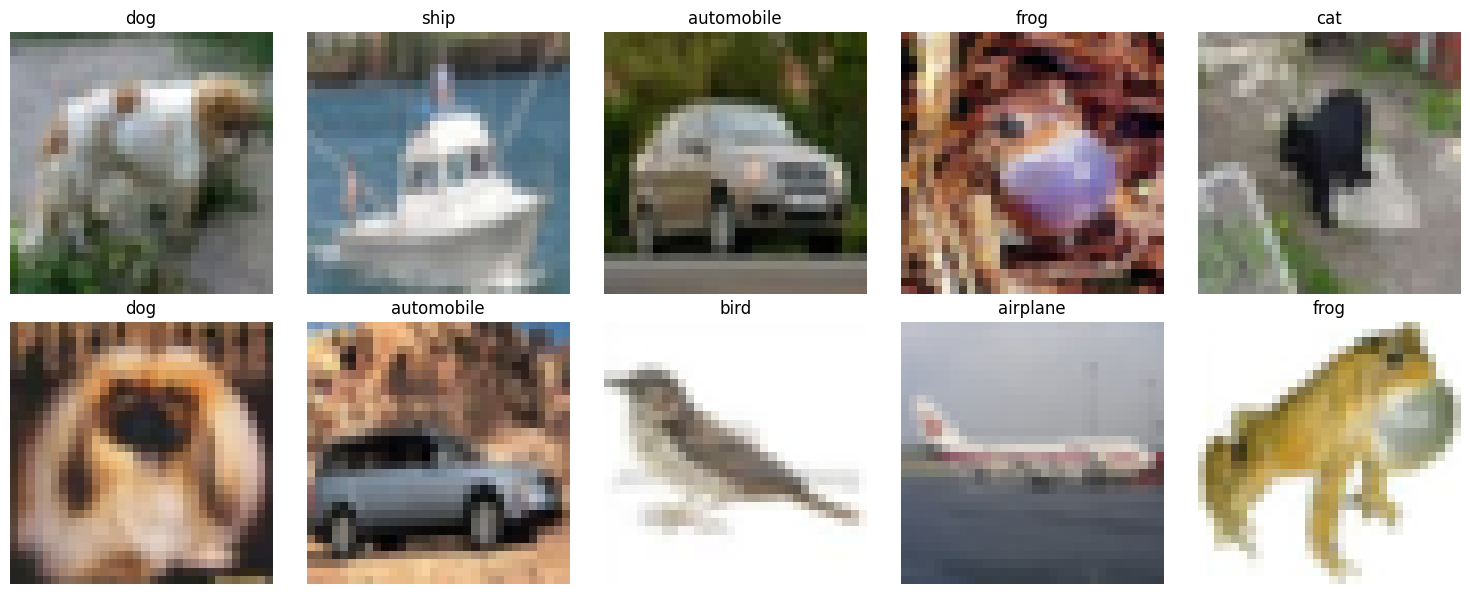

In [8]:
# ============================================================
# 7. 샘플 이미지 시각화 (랜덤)
# ============================================================
import random

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# 랜덤 인덱스 생성
random_indices = random.sample(range(len(train_dataset_raw)), 10)

for i, ax in enumerate(axes.flat):
    image, label = train_dataset_raw[random_indices[i]]
    ax.imshow(image)
    ax.set_title(f"{class_names[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# 8. 모델 생성
# ============================================================
from src.model import print_model_list, create_model, print_model_info

print_model_list()

model = create_model(SELECTED_MODEL, num_classes, pretrained=True)
model = model.to(device)

print_model_info(model, device)

📋 사용 가능한 모델 목록

🔹 EfficientNet:
👉  1. EfficientNet-B0           (efficientnet_b0)
    2. EfficientNet-B1           (efficientnet_b1)
    3. EfficientNet-B2           (efficientnet_b2)
    4. EfficientNet-B3           (efficientnet_b3)

🔹 ResNet:
    5. ResNet-18                 (resnet18)
    6. ResNet-34                 (resnet34)
    7. ResNet-50                 (resnet50)
    8. ResNet-101                (resnet101)

🔹 ViT (Vision Transformer):
    9. ViT-Tiny                  (vit_tiny_patch16_224)
   10. ViT-Small                 (vit_small_patch16_224)

🔹 ConvNeXt:
   11. ConvNeXt-Tiny             (convnext_tiny)
   12. ConvNeXt-Small            (convnext_small)

🔹 MobileNet:
   13. MobileNetV3-Small         (mobilenetv3_small_100)
   14. MobileNetV3-Large         (mobilenetv3_large_100)

✅ 현재 선택된 모델: EfficientNet-B0 (efficientnet_b0)
💡 모델 변경 방법: src/config.py에서 MODEL_NAME을 수정하세요

📊 모델 정보
  모델 이름:           EfficientNet-B0
  전체 파라미터:       4,020,358
  학습 가능 파라미터:  4,020,358
  고정 

In [ ]:
# ============================================================
# 9. 모델 학습
# ============================================================
from src.train import run_kfold_training

# NOTE: run_kfold_training 내부에서 매 fold마다 모델을 생성하므로 model 인자는 사용되지 않습니다.
config_dict = {
    'EPOCHS': EPOCHS,
    'BATCH_SIZE': BATCH_SIZE,
    'LR': LR,
    'N_FOLDS': N_FOLDS,
    'PATIENCE': PATIENCE,
    'MODEL_NAME': SELECTED_MODEL
}

# NOTE: run_kfold_training 내부에서 매 fold마다 모델을 생성하므로 model 인자는 사용되지 않습니다.
fold_results = run_kfold_training(
    model=None,
    train_dataset_raw=train_dataset_raw,
    train_labels=train_labels,
    train_transform=train_transform,
    val_transform=val_transform,
    num_classes=num_classes,
    device=device,
    config_dict=config_dict,
    use_wandb=True
)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (949459475.py, line 7)

In [ ]:
# ============================================================
# 10. 평가 및 결과 분석
# ============================================================
import platform
import matplotlib.pyplot as plt

# 한글 폰트 설정 (즉시 적용)
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

from src.evaluation import run_full_evaluation

results = run_full_evaluation(
    fold_results=fold_results,
    test_dataset=test_dataset,
    test_dataset_raw=test_dataset_raw,
    class_names=class_names,
    device=device,
    batch_size=BATCH_SIZE,
    num_classes=num_classes,
    use_wandb=True
)

In [ ]:
# ============================================================
# 11. 실험 결과 저장 (간소화)
# ============================================================
from src.logger import log_experiment_results

log_experiment_results(
    project_root=project_root,
    fold_results=fold_results,
    results=results,
)
